Library import and data loading 

In [1]:


if 'libraries_imported' not in globals():
    libraries_imported = False

if not libraries_imported:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from datetime import datetime, timedelta

    # Plotly libraries
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.io as pio

    # SciPy libraries
    from scipy.interpolate import make_interp_spline
    from scipy.signal import butter, filtfilt

    # TensorFlow and Keras for neural networks
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.regularizers import l1_l2

    # Scikit-learn for model preparation and evaluation
    from sklearn.model_selection import train_test_split, KFold, GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_absolute_error

    # Ensemble and boosting models
    from xgboost import XGBRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.tree import DecisionTreeRegressor

    # Additional utilities
    import logging
    import joblib 
    import matplotlib.dates as mdates

    from model_definitions import create_model
    from tensorflow.keras.models import load_model


        


    logging.getLogger('tensorflow').setLevel(logging.ERROR)

    # Optionally, to suppress absl (used by TensorFlow) messages as well:
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)


    # Placeholder for DataFrame
    df_annotations = None

    # Set plot size for Seaborn
    sns.set(rc={'figure.figsize':(17,8.27)})

    # Set the flag to True to indicate libraries are imported
    libraries_imported = True

# Set plot size for Seaborn (outside the if condition)
sns.set(rc={'figure.figsize':(17,8.27)})


2024-02-27 23:43:26.333443: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 23:43:26.361996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 23:43:26.921814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Functions 

In [2]:

def apply_fig_format(fig_x, w=2000, h=600, subplot=False, n_cols=1, n_rows=1):
    xaxis_args=dict(
            tickfont=dict(size=18),
            title_font=dict(size=22),
            gridcolor='lightgray',
            linecolor='gray',
            linewidth=1,
            mirror=True,
            showline=True,
            dtick='D'
        )
    yaxis_args=dict(
            tickfont=dict(size=18),
            title_font=dict(size=22),
            gridcolor='lightgray',
            linecolor='gray',
            linewidth=1,
            mirror=True,
            showline=True,
        )

    fig_x.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        width=w,
        height=h,
     )

    if subplot:
        for i in range(1, n_cols*n_rows+1):
            fig_x['layout']['xaxis'+str(i)].update(xaxis_args)
            fig_x['layout']['yaxis'+str(i)].update(yaxis_args)
    else:
        fig_x['layout']['xaxis'].update(xaxis_args)
        fig_x['layout']['yaxis'].update(yaxis_args)




    fig_x.show()


def apply_date_range_df(df):
  df = df[df['datetime'].dt.date >= date_start]
  df = df[df['datetime'].dt.date <= date_end]
  return df

Data insepctions


In [3]:

joined_df = pd.read_csv('complete_data.csv')
joined_df.head()
joined_df.set_index('datetime', inplace=True)
joined_df_interpolated = joined_df.interpolate(method='linear')
# Apply backward fill
joined_df_interpolated_bfilled = joined_df_interpolated.bfill()
# Display the first few rows after processing to check for successful interpolation
joined_df_interpolated_bfilled.head()
dataset = joined_df_interpolated_bfilled
dataset.reset_index(inplace=True)

display(dataset.head())

fig = go.Figure()

fig.add_trace(go.Scatter(x= dataset['datetime'],
                         y= dataset['CO2'],
                         mode='lines',
                         line=dict(color='red'),
                         name='Interval Over Time'))

fig.update_layout(
    title="CH4%",
    xaxis_title="Datetime",
    yaxis_title="CH4%",
    xaxis_showgrid=True,
    yaxis_showgrid=True
)

apply_fig_format(fig, 800, 300)


fig = go.Figure()

fig.add_trace(go.Scatter(x= dataset['datetime'],
                         y= dataset['sCOD_kg/m3'],
                         mode='lines',
                         line=dict(color='red'),
                         name='Interval Over Time'))

fig.update_layout(
    title="sCOD_kg/m3",
    xaxis_title="Datetime",
    yaxis_title="sCOD_kg/m3",
    xaxis_showgrid=True,
    yaxis_showgrid=True
)

apply_fig_format(fig, 800, 300)



fig = go.Figure()

fig.add_trace(go.Scatter(x= dataset['datetime'],
                         y= dataset['A Current_daily_avg'],
                         mode='lines',
                         line=dict(color='red'),
                         name='A Current_daily_avg'))

fig.update_layout(
    title="A Current_daily_avg",
    xaxis_title="Datetime",
    yaxis_title="A Current_daily_avg",
    xaxis_showgrid=True,
    yaxis_showgrid=True
)

apply_fig_format(fig, 800, 300)


# dataset.to_csv('dataset.csv')



df = dataset.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.groupby('datetime').mean()

df['A Current_daily_avg_lag1d_dt'] = df['A Current_daily_avg'].shift(freq='1D')
df['CH4%_lag1d_dt'] = df['CH4%'].shift(freq='1D')
df['CO2_lag1d_dt'] = df['CO2'].shift(freq='1D')
df['ntp_volume_this_tip_intervalml_daily_avg_lag1d_dt'] = df['ntp_volume_this_tip_intervalml_daily_avg'].shift(freq='1D')


df = df.bfill()
dataset = df.copy()
dataset.reset_index(inplace=True)




,datetime,Unnamed: 0,interval_minutes,index,ntp_volume_this_tip_intervalml,A Current,Peaks,Troughs,Peaks_daily_avg,Troughs_daily_avg,...,CH4%,CO2,H2S,TE,TS,VS,TSS,COND,VFA,sample_vol
0,2023-11-12 00:00:00,0,780.0,0.0,87.288242,48.264,54.541,45.038,53.6395,44.738,...,58.7,40.0,1164.0,4.0,41.2,29.3,26.0,14.57,8505.0,15.0
1,2023-11-12 00:10:00,1,780.0,1042.0,80.825427,48.049,54.541,45.038,53.6395,44.738,...,58.7,40.0,1164.0,4.0,41.2,29.3,26.0,14.57,8505.0,15.0
2,2023-11-12 00:20:00,2,780.0,1043.0,74.362613,47.909,54.541,45.038,53.6395,44.738,...,58.7,40.0,1164.0,4.0,41.2,29.3,26.0,14.57,8505.0,15.0
3,2023-11-12 00:30:00,3,780.0,1044.0,67.899799,47.725,54.541,45.038,53.6395,44.738,...,58.7,40.0,1164.0,4.0,41.2,29.3,26.0,14.57,8505.0,15.0
4,2023-11-12 00:40:00,4,780.0,1045.0,61.436984,47.546,54.541,45.038,53.6395,44.738,...,58.7,40.0,1164.0,4.0,41.2,29.3,26.0,14.57,8505.0,15.0


Inital NN trial

In [4]:


# columns_to_drop = ['COD_kg/m3', 'TE', 'TS',  'sample_vol', 'index', 'TSS', 'VS', 'VFA', 'Unnamed: 0', 'CH4%', 'CO2', 'H2S', 'CH4%_lag1d_dt','CO2_lag1d_dt']
# dataset = dataset.drop(columns=columns_to_drop, axis=1)






# print(dataset.columns)

# display(dataset)

# # Drop rows where the target variable 'sCOD_kg/m3' is still missing after interpolation
# # dataset = dataset.dropna(subset=['sCOD_kg/m3'])

# # Select features and target variable
# X = dataset.drop(['sCOD_kg/m3', 'datetime'], axis=1)  # Drop non-feature columns
# y = dataset['sCOD_kg/m3']

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# # Scale the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# joblib.dump(scaler, 'scaler.pkl')

# # Define a list of models to evaluate
# models = [
#     Sequential([
#         Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), input_shape=(X_train.shape[1],)),
#         Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
#         Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
#         Dense(1)
#     ]),
#     Sequential([
#         Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), input_shape=(X_train.shape[1],)),
#         Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
#         Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
#         Dense(1)
#     ]),
#     Sequential([
#         Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), input_shape=(X_train.shape[1],)),
#         Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
#         Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
#         Dense(1)
#     ])
# ]

# # Create a dictionary to store model names and losses
# model_losses = {}

# # Compile and train each model
# for i, model in enumerate(models):
#     # Compile the model with a smaller learning rate
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mean_absolute_error')

#     # Add a callback to check for NaN values during training
#     class TerminateOnNaN(tf.keras.callbacks.Callback):
#         def on_epoch_end(self, epoch, logs=None):
#             if logs.get('loss') is not None and np.isnan(logs.get('loss')):
#                 print('NaN loss detected, stopping training')
#                 self.model.stop_training = True

#     # Train the model
#     model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=[TerminateOnNaN()])

#     # Evaluate the model
#     loss = model.evaluate(X_test, y_test)
#     print(f"Model Loss: {loss}")

#     # Add model name and loss to the dictionary
#     model_losses[f"Model {i+1}"] = loss

# # Print the model names and losses
# for model_name, loss in model_losses.items():
#     print(f"{model_name}: {loss}")




Comparison of -- Keras regressor, XGBoost, Random Forest, Decision Tree, Gradient Boosting (with grid search and cross validation)

In [5]:
columns_to_drop = ['TSS', 'COD_kg/m3', 'VS',  'TE', 'TS',  'sample_vol', 'index', 'VFA', 'Unnamed: 0', 'CH4%', 'CO2', 'H2S', 'CH4%_lag1d_dt','CO2_lag1d_dt']
dataset = dataset.drop(columns=columns_to_drop, axis=1)



# Select features and target variable
X = dataset.drop(['sCOD_kg/m3', 'datetime'], axis=1)  # Drop non-feature columns
y = dataset['sCOD_kg/m3']

print(X.columns)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




joblib.dump(scaler, 'scaler.pkl')


def create_model(layers=[64, 32, 16], input_shape=(10,), learning_rate=0.001):
    model = Sequential()
    model.add(Dense(layers[0], activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), input_shape=input_shape))
    for layer_size in layers[1:]:
        model.add(Dense(layer_size, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    return model

# Define a custom callback for handling NaN loss
class TerminateOnNaN(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') is not None and np.isnan(logs.get('loss')):
            print('NaN loss detected, stopping training')
            self.model.stop_training = True

# Define the list of models and their corresponding hyperparameters, including neural networks with varying architectures
models = [
    {
        'model': KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, input_shape=[X_train.shape[1]], verbose=0, callbacks=[TerminateOnNaN()]),
        'params': {
            # 'epochs': [10, 20, 30],
            # 'batch_size': [16, 32, 64],
            # 'layers': [[64, 32, 16], [128, 64, 32], [32, 16, 8]],
            # 'learning_rate': [0.01, 0.001, 0.0001]

            'epochs': [30],
            'batch_size': [32],
            'layers': [[128, 64, 32]],
            'learning_rate': [0.001]
        }

    },

    #     {
    #     'model': XGBRegressor(),
    #     'params': {
    #         'n_estimators': [100, 200, 300],
    #         'max_depth': [3, 4, 5],
    #         'learning_rate': [0.1, 0.01, 0.001]
    #     }
    # },
    # {
    #     'model': RandomForestRegressor(),
    #     'params': {
    #         'n_estimators': [100, 200, 300],
    #         'max_depth': [3, 4, 5]
    #     }
    # },
    # {
    #     'model': DecisionTreeRegressor(),
    #     'params': {
    #         'max_depth': [3, 4, 5]
    #     }
    # },
    # {
    #     'model': GradientBoostingRegressor(),
    #     'params': {
    #         'n_estimators': [100, 200, 300],
    #         'max_depth': [3, 4, 5],
    #         'learning_rate': [0.1, 0.01, 0.001]
    #     }
    # }


]


best_models = {}

# Perform grid search for each model, now including neural network architecture exploration
for i, model_info in enumerate(models):
    model = model_info['model']
    params = model_info['params']
    
    grid_search = GridSearchCV(model, params, cv=3, scoring='neg_mean_absolute_error', verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"Best parameters for {model.__class__.__name__}: {best_params}")
    print(f"Best score for {model.__class__.__name__}: {best_score}")
    
    # Save the best model from the grid search
    best_model = grid_search.best_estimator_
    best_models[model.__class__.__name__] = best_model
    joblib.dump(best_model, f'model_{i}_{model.__class__.__name__}.joblib')



Index(['interval_minutes', 'ntp_volume_this_tip_intervalml', 'A Current',
       'Peaks', 'Troughs', 'Peaks_daily_avg', 'Troughs_daily_avg',
       'A Current_daily_avg', 'ntp_volume_this_tip_intervalml_daily_avg', 'pH',
       'COND', 'A Current_daily_avg_lag1d_dt',
       'ntp_volume_this_tip_intervalml_daily_avg_lag1d_dt'],
      dtype='object')
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/tmp/ipykernel_65342/2950387659.py:46: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.

2024-02-27 23:43:27.627533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 23:43:27.632222: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Best parameters for KerasRegressor: {'batch_size': 32, 'epochs': 30, 'layers': [128, 64, 32], 'learning_rate': 0.001}
Best score for KerasRegressor: -0.24330779870865463


2024-02-27 23:43:36.499655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-27 23:43:36.525204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-27 23:43:36.576026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-27 23:43:36.601372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-27 23:43:36.651889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-27 23:43:36.880281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-27 23:43:36.969479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-27 23:43:37.067418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-

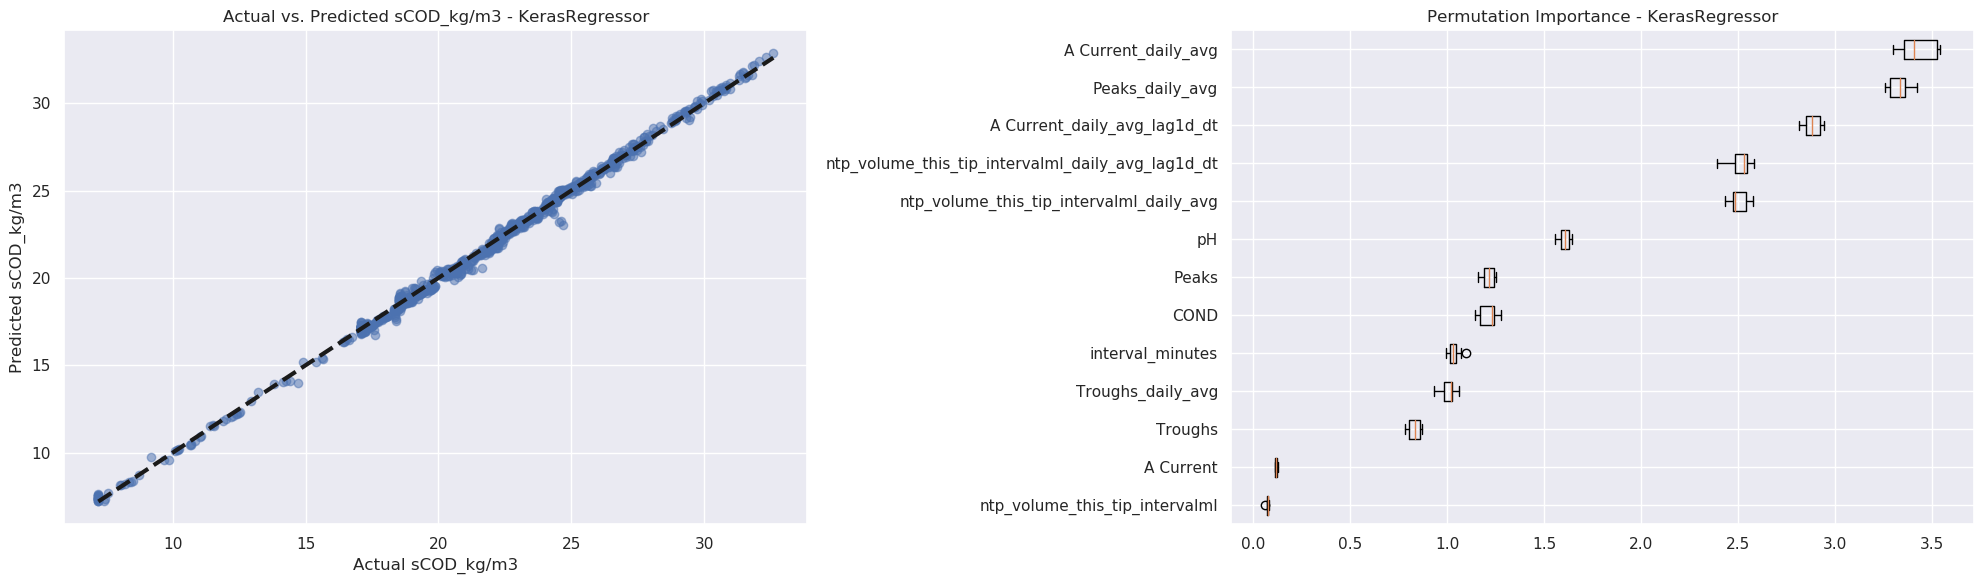

In [6]:
from sklearn.inspection import permutation_importance

feature_names = list(X.columns)

for model_name, model in best_models.items():
    # Generate predictions using the trained model
    y_pred = model.predict(X_test)

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plotting the predictions vs the actual values on the first subplot
    axs[0].scatter(y_test, y_pred, alpha=0.5)
    axs[0].set_xlabel('Actual sCOD_kg/m3')
    axs[0].set_ylabel('Predicted sCOD_kg/m3')
    axs[0].set_title(f'Actual vs. Predicted sCOD_kg/m3 - {model_name}')
    axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Ideal line for perfect predictions

    # Compute permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()

    # Plotting permutation importance on the second subplot
    axs[1].boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
    axs[1].set_title(f'Permutation Importance - {model_name}')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [7]:

original_dataset = dataset 

# Load the test data
test_df = pd.read_csv('live_implementation_data.csv')
columns_to_drop = ['TSS', 'COD_kg/m3','VS', 'TE', 'TS', 'sample_vol', 'index', 'VFA', 'Unnamed: 0', 'CH4%', 'CO2', 'H2S']
test_df_interpolated = test_df.interpolate(method='linear')
test_df_interpolated_bfilled = test_df_interpolated.bfill()
test_df_interpolated_bfilled = test_df_interpolated_bfilled.drop(columns=columns_to_drop)

test_df_interpolated_bfilled['datetime'] = pd.to_datetime(test_df_interpolated_bfilled['datetime'])
test_dataset = test_df_interpolated_bfilled.groupby('datetime').mean()
# test_dataset.set_index('datetime', inplace=True)
test_dataset['A Current_daily_avg_lag1d_dt'] = test_dataset['A Current_daily_avg'].shift(freq = '1D')
test_dataset['ntp_volume_this_tip_intervalml_daily_avg_lag1d_dt'] = test_dataset['ntp_volume_this_tip_intervalml_daily_avg'].shift(freq = '1D')
test_dataset = test_dataset.bfill()
display(test_dataset.reset_index(inplace=True))



df = test_dataset.copy()
date_series = df['datetime'].dt.date

# Convert to list
date_list = date_series.tolist()

# Remove duplicates
unique_dates = list(set(date_list))

# Sort the unique dates
sorted_unique_dates = sorted(unique_dates)

# Print the sorted list of unique dates
print(sorted_unique_dates)









combined_df = pd.concat([original_dataset, test_dataset.sample(frac=0.3)])

# num_rows = int(len(test_dataset) * 0.3)
# first_20_percent = test_dataset.iloc[:num_rows]
# combined_df = pd.concat([original_dataset, first_20_percent])





combined_df.drop(columns=['datetime'], inplace=True)  

# Prepare combined dataset for model training
X_combined = combined_df.drop(['sCOD_kg/m3'], axis=1)  # Assuming 'VS' is the target variable
y_combined = combined_df['sCOD_kg/m3']

# Scale features
scaler = StandardScaler().fit(X_combined)
X_combined_scaled = scaler.transform(X_combined)



X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.4, random_state=20)

# Scale features (fit on training data only)
scaler = StandardScaler().fit(X_train)

# Transform both training and validation data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Load the model and retrain
best_model = joblib.load('model_0_KerasRegressor.joblib')
best_model.fit(X_train_scaled, y_train)

save_model = best_model.model


save_model.save('my_model.h5') 
y_pred_val = best_model.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_pred_val)


print(f'Mean Absolute Error on Validation Set: {mae}')
test_dataset.drop(columns=['datetime'], inplace=True) 
X_test_new = scaler.transform(test_dataset.drop(['sCOD_kg/m3', 'datetime'], axis=1, errors='ignore')) 
y_pred = best_model.predict(X_test_new)
test_dataset.reset_index(inplace=True)






None

[datetime.date(2024, 1, 27), datetime.date(2024, 1, 28), datetime.date(2024, 1, 29), datetime.date(2024, 1, 30), datetime.date(2024, 1, 31), datetime.date(2024, 2, 1), datetime.date(2024, 2, 2), datetime.date(2024, 2, 3), datetime.date(2024, 2, 4)]
Mean Absolute Error on Validation Set: 0.8555995420905286


In [8]:
trace1 = go.Scatter(
    x= df['datetime'],
    y=y_pred,
    mode='markers',
    marker=dict(color='blue', symbol='x'),
    name='Predicted',
    opacity=0.5
)

trace2 = go.Scatter(
    x= df['datetime'],
    y=test_dataset['sCOD_kg/m3'],
    mode='markers',
    marker=dict(color='red', symbol='circle'),
    name='Actual',
    opacity=0.5
)

# Create the figure
fig = go.Figure(data=[trace1, trace2])

# Update layout
fig.update_layout(
    title='Predicted sCOD over Time',
    xaxis_title='Datetime',
    yaxis_title= 'sCOD_kg/m3',
    xaxis=dict(
        # Uncomment and adjust the line below for datetime formatting, if needed
        # tickformat='%Y-%m-%d', 
        # tickmode='auto',  # or 'array', with tickvals and ticktext
    ),
    legend=dict(y=1, x=1),
    hovermode='closest',
    template='plotly',  # Choose a template as per your preference
    width=1200,  # Adjust the size as needed
    height=700
)



apply_fig_format(fig, 1200, 600)





